In [2]:
# Import Lib

import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable 
import copy
from matplotlib.font_manager import FontProperties
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import random
import heapq
import wandb
import matplotlib.pyplot as plt
# Set device (CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# !wandb login 6a66920f640c7001ec17ad4aa7a5da8b378aee61

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


## PREPROCESSING

In [4]:
def encode(x, max_length, char_to_idx):
    encoded = np.zeros(max_length, dtype=int)
    encoder = np.array([char_to_idx[char] for char in x])
    length = min(max_length, len(encoder))
    encoded[:length] = encoder[:length]

    return torch.tensor(encoded, dtype=torch.int64), length

def get_tensor_object(df, max_input_length, max_output_length, char_to_idx_input, char_to_idx_output):
    # Encode unique inputs and outputs into tensors
    encoded_inputs = []
    encoded_outputs = []

    # Encode the input column
    for input_str in df[0]:
        encoded_input, input_length = encode(input_str, max_input_length, char_to_idx_input)
        encoded_inputs.append(encoded_input)

    # Encode the output column
    for output_str in df[1]:
        encoded_output, output_length = encode(output_str, max_output_length, char_to_idx_output)
        encoded_outputs.append(encoded_output)

    # Stack tensors column-wise
    
#     tensor_inputs = torch.stack(encoded_inputs, dim=1)
#     tensor_outputs = torch.stack(encoded_outputs, dim=1)
    tensor_inputs = torch.stack(encoded_inputs)
    tensor_outputs = torch.stack(encoded_outputs)

    return tensor_inputs, tensor_outputs

def load_dataset(path):
    """
    Load a dataset from a TSV file.
    Args:
    - path (str): Path to the TSV file.
    Returns:
    - df (pd.DataFrame): Loaded DataFrame.
    - max_input_length (int): Maximum length for input sequences.
    - max_output_length (int): Maximum length for output sequences.
    """
    df = pd.read_csv(path, header=None, encoding='utf-8', sep='\t')  # Changed separator to tab
    
    # Convert values to strings before adding special characters
    df[0] = df[0].astype(str).apply(lambda x: x + '$')
    df[1] = df[1].astype(str).apply(lambda x: '^' + x + '$')
    
    # Determine maximum length for input and output sequences
    max_input_length = max(len(x) for x in df[0].unique())
    max_output_length = max(len(x) for x in df[1].unique())
    return df, max_input_length, max_output_length

def look_up_table(vocab1, vocab2, vocab3):
    # Combine all vocabularies into one set
    vocab = set(''.join(vocab1) + ''.join(vocab2) + ''.join(vocab3))
    vocab.discard('^')  
    vocab.discard('$')  
    vocab_to_int = {"": 0, '^':1, '$':2}
    for v_i, v in enumerate(sorted(vocab), len(vocab_to_int)):
        vocab_to_int[v] = v_i
    int_to_vocab = {v_i: v for v, v_i in vocab_to_int.items()}
    return vocab_to_int, int_to_vocab




# Load Dataset
df_train, train_input_len, train_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv')
df_val, val_input_len, val_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv')
df_test, test_input_len, test_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv')

input_max_len = max(train_input_len, val_input_len, test_input_len) + 1
output_max_len = max(train_out_len, val_out_len, test_out_len) + 1


# Create Look Up Table
input_char_to_int, input_int_to_char = look_up_table(df_train[0], df_val[0], df_test[0])
output_char_to_int, output_int_to_char = look_up_table(df_train[1], df_val[1], df_test[1])

print("Input Lookup Table:", input_char_to_int)
print("\n\n Output Lookup Table", output_char_to_int)

# Data Embedding and Converting them into Tensor
train_inputs, train_outputs = get_tensor_object(df_train, input_max_len, input_max_len, input_char_to_int, output_char_to_int)
val_inputs, val_outputs = get_tensor_object(df_val, input_max_len, input_max_len, input_char_to_int, output_char_to_int)
test_inputs, test_outputs = get_tensor_object(df_test, input_max_len, input_max_len, input_char_to_int, output_char_to_int)

# Transpose column wise
train_inputs, train_outputs = torch.transpose(train_inputs, 0, 1), torch.transpose(train_outputs, 0, 1)
val_inputs, val_outputs = torch.transpose(val_inputs, 0, 1), torch.transpose(val_outputs, 0, 1)
test_inputs, test_outputs = torch.transpose(test_inputs, 0, 1), torch.transpose(test_outputs, 0, 1)


print("\n", train_inputs[:,0],train_outputs[:,0])
print("Training Input:", train_inputs.shape, train_outputs.shape)

print("Validation", val_inputs.shape, val_inputs.shape)
print(df_train.head())

Input Lookup Table: {'': 0, '^': 1, '$': 2, 'ँ': 3, 'ं': 4, 'ः': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ए': 13, 'ऐ': 14, 'ऑ': 15, 'ओ': 16, 'औ': 17, 'क': 18, 'ख': 19, 'ग': 20, 'घ': 21, 'ङ': 22, 'च': 23, 'छ': 24, 'ज': 25, 'झ': 26, 'ञ': 27, 'ट': 28, 'ठ': 29, 'ड': 30, 'ढ': 31, 'ण': 32, 'त': 33, 'थ': 34, 'द': 35, 'ध': 36, 'न': 37, 'प': 38, 'फ': 39, 'ब': 40, 'भ': 41, 'म': 42, 'य': 43, 'र': 44, 'ल': 45, 'व': 46, 'श': 47, 'ष': 48, 'स': 49, 'ह': 50, '़': 51, 'ा': 52, 'ि': 53, 'ी': 54, 'ु': 55, 'ू': 56, 'ृ': 57, 'ॅ': 58, 'े': 59, 'ै': 60, 'ॉ': 61, 'ो': 62, 'ौ': 63, '्': 64, 'ॐ': 65}


 Output Lookup Table {'': 0, '^': 1, '$': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}

 tensor([6, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) tensor([ 1,  3, 16,  2,  0,  0,  0,  0,  0,  0, 

# Create Seq2Seq CLass

In [5]:
class Encoder(nn.Module): 
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout, bidirectional, cell_type):
        super(Encoder, self).__init__()
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(dropout)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.cell_type = cell_type
        
        # Define embedding layer
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        # Define RNN layer with specific cell type
        if cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        elif cell_type == 'RNN':
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout, bidirectional=bidirectional)
        else:
            raise ValueError("Invalid RNN type. Choose from 'LSTM', 'GRU', or 'RNN'.")
        
        
    def forward(self, x): # x shape: (seq_length, N) where N is batch size
        # Perform dropout on the input
        embedding = self.embedding(x)
        embedding = self.dropout(embedding) # embedding shape: (seq_length, N, embedding_size)
        
        if self.cell_type == "LSTM":
            # Pass through the LSTM layer
            outputs, (hidden, cell) = self.rnn(embedding) # outputs shape: (seq_length, N, hidden_size)
            if self.bidirectional:
                # Sum the bidirectional outputs
                outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
                hidden = torch.cat((hidden[: self.num_layers], hidden[self.num_layers:]), dim=0)

            # Return hidden state and cell state
            return outputs, hidden, cell
        elif self.cell_type == "GRU" or self.cell_type == "RNN":
            # Pass through the RNN/GRU layer
            outputs, hidden = self.rnn(embedding) # outputs shape: (seq_length, N, hidden_size)
            if self.bidirectional:
                # Sum the bidirectional outputs
                outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
                hidden = torch.cat((hidden[: self.num_layers], hidden[self.num_layers:]), dim=0)

            # Return output (max_seq, N, hidden size)
            return outputs, hidden 
        else:
            print("Encoder Failed to initialize!")
            return None

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
      
    def dot_score(self, hidden_state, encoder_states):
        return torch.sum(hidden_state * encoder_states, dim=2)
    
    def forward(self, hidden, encoder_outputs):
        attn_scores = self.dot_score(hidden, encoder_outputs)
        attn_scores = attn_scores.t()  # Transpose to match dimensions
        attention_weights = F.softmax(attn_scores, dim=1).unsqueeze(1)
        return attention_weights

class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout, bidirection_type, cell_type):
        super(Decoder, self).__init__()
        self.bidirectional = bidirection_type
        self.dropout = nn.Dropout(dropout)  
        self.num_layers = num_layers 
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.cell_type = cell_type
        
        
        # Define embedding layer
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        # Define RNN layer with specific cell type
        if cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout)
        elif cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout)
        elif cell_type == 'RNN':
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout)
        else:
            raise ValueError("Invalid RNN type. Choose from 'LSTM', 'GRU', or 'RNN'.")
        
        
            
        # Define fully connected layer
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)  
        
        # Attention Class object
        self.attn = Attention(hidden_size)
        
        # Softmax layer
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x, encoder_outputs, hidden, cell): # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        
        
        # Ensure x has the shape (1, N)
        x = x.unsqueeze(0)
        
        # Perform dropout on the input
        embedding = self.embedding(x)
        embedding = self.dropout(embedding)  # embedding shape: (1, N, embedding_size)
        
        if self.cell_type == "LSTM":
            # Pass through the LSTM layer
            outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))  # outputs shape: (1, N, hidden_size * num_directions)
            
            # Calculate attention weights
            attention_weights = self.attn(outputs, encoder_outputs)
            context = attention_weights.bmm(encoder_outputs.transpose(0, 1))
            
            # Concatenate  context vector and GRU output
            outputs = outputs.squeeze(0)
            context = context.squeeze(1)
            concat_input = torch.cat((outputs, context), 1)
            concat_output = torch.tanh(self.concat(concat_input))
            
            # Pass through fully connected layer
            out = self.fc(concat_output)
            predictions = self.log_softmax(out)

            return predictions, hidden, cell, attention_weights.squeeze(1)
        
        elif self.cell_type == "GRU" or self.cell_type == "RNN":
            # Pass through the  layer
            outputs, hidden = self.rnn(embedding, hidden)  # outputs shape: (1, N, hidden_size * num_directions)
            
            # Calculate attention weights
            attention_weights = self.attn(outputs, encoder_outputs)
            context = attention_weights.bmm(encoder_outputs.transpose(0, 1))
            
            # Concatenate  context vector and GRU output
            outputs = outputs.squeeze(0)
            context = context.squeeze(1)
            concat_input = torch.cat((outputs, context), 1)
            concat_output = torch.tanh(self.concat(concat_input))

            
            # Pass through fully connected layer
            out = self.fc(concat_output)
            predictions = self.log_softmax(out)
            
            return predictions, hidden, attention_weights.squeeze(1)
    
        else:
            print("Encoder Failed to initialized!!!!!!!!")
            return None
        
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder, output_char_to_int, teacher_forcing, cell_type):

        super(Seq2Seq, self).__init__()  
        # Initialize encoder and decoder
        self.decoder = decoder
        self.encoder = encoder
        self.cell_type = cell_type
        self.target_vocab_size =  len(output_char_to_int)
        self.teacher_force_ratio = teacher_forcing
    
#     def create_mask(self, input_sequence):
#         return (input_sequence != 0).permute(1, 0)
    
    def forward(self, source, target):
        
        # Get batch size, target length, and target vocabulary size
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = self.target_vocab_size
        teacher_force_ratio = self.teacher_force_ratio
        
        # Initialize outputs tensor
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        # Grab the first input to the Decoder which will be <SOS> token i.e '^'
        x = target[0,:]
        
        # Get hidden state and cell state from encoder
        if self.cell_type == 'LSTM':
            encoder_outputs, hidden, cell = self.encoder(source)
            hidden =  hidden[:self.decoder.num_layers]
            cell =  cell[:self.decoder.num_layers]
        else:
            encoder_outputs, hidden = self.encoder(source)
            hidden =  hidden[:self.decoder.num_layers]
        
        for t in range(1, target_len):
            # Use previous hidden and cell states as context from encoder at start
            if self.cell_type == 'LSTM':
                output, hidden, cell, _ = self.decoder(x, encoder_outputs, hidden, cell)
            else:
                output, hidden, _ = self.decoder(x, encoder_outputs, hidden, None)
            #output, hidden, cell = self.decoder(x, hidden, cell)
                
            # Store next output prediction
            outputs[t], best_guess = output, output.argmax(1)
            # Get the best word the Decoder predicted (index in the vocabulary)
            x = best_guess if random.random() >= teacher_force_ratio else target[t]

        return outputs

## TRAINING

In [6]:
# BEAM SEARCH FUNCTION
def beam_search(model, input_seq, max_length, input_char_index, output_char_index, reverse_target_char_index, beam_width, length_penalty, cell_type):
    if len(input_seq) > max_length:
        print("Input Length is exceeding max length!!!!")
        return ""
    
    # Create np array of zero of length i/p 
    input_data = np.zeros((max_length, 1), dtype=int) # (N,1)
    
    # Encode the input
    for idx, char in enumerate(input_seq):
        input_data[idx, 0] = input_char_index[char]
    input_data[idx+1, 0] = input_char_index["$"] # EOS
    
    # Convert to tensor
    input_tensor = torch.tensor(input_data, dtype=torch.int64).to(device) # N,1
    
    with torch.no_grad():
        if cell_type == 'LSTM':
            encoder_outputs, hidden, cell = model.encoder(input_tensor)
            hidden =  hidden[:model.decoder.num_layers]
            cell =  cell[:model.decoder.num_layers]
        else:
            encoder_outputs, hidden = model.encoder(input_tensor)
            hidden =  hidden[:model.decoder.num_layers]
    
    # Initialize beam
    out_t = output_char_index['^']
    out_reshape = np.array(out_t).reshape(1,)
    hidden_par = hidden.unsqueeze(0)
    initial_sequence = torch.tensor(out_reshape).to(device)
    beam = [(0.0, initial_sequence, hidden_par)]  # [(score, sequence, hidden)]

    for _ in range(len(output_char_index)):
        candidates = []
        for score, seq, hidden in beam:
            if seq[-1].item() == output_char_index['$']:
                # If the sequence ends with the end token, add it to the candidates
                candidates.append((score, seq, hidden))
                continue
            
            last_token = np.array(seq[-1].item()).reshape(1,)
            x = torch.tensor(last_token).to(device)
            
            if cell_type == 'LSTM':
                output, hidden, cell, _ = model.decoder(x, encoder_outputs, hidden.squeeze(0), cell)
            else:
                output, hidden, _ = model.decoder(x, encoder_outputs, hidden.squeeze(0), None)
                
            probabilities = F.softmax(output, dim=1)
            topk_probs, topk_tokens = torch.topk(probabilities, k=beam_width)

            for prob, token in zip(topk_probs[0], topk_tokens[0]):
                new_seq = torch.cat((seq, token.unsqueeze(0)), dim=0)
                seq_length_norm_factor = (len(new_seq) - 1) / 5
                candidate_score = score + torch.log(prob).item() / (seq_length_norm_factor ** length_penalty)
                candidates.append((candidate_score, new_seq, hidden.unsqueeze(0)))

        # Select top-k candidates based on the accumulated scores
        beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[0])

    best_score, best_sequence, _ = max(beam, key=lambda x: x[0])  # Select the best sequence from the beam as the output

    # Convert the best sequence indices to characters
    return ''.join([reverse_target_char_index[token.item()] for token in best_sequence[1:]])


# TRAINING FUNCTION
def train(model, num_epochs, criterion, optimizer, train_batch_x, train_batch_y, val_batch_x, val_batch_y, df_val, input_char_to_int, output_char_to_int, output_int_to_char, beam_width, length_penalty, cell_type, max_length):
    for epoch in range(num_epochs):
        total_words = 0
        correct_pred = 0
        total_loss = 0
        accuracy = 0
        model.train()
        
        # Use tqdm for progress tracking
        train_data_iterator = tqdm(zip(train_batch_x, train_batch_y), total=len(train_batch_x))
        
        for (x, y) in train_data_iterator:
            # Get input and targets and move to device
            target, inp_data = y.to(device), x.to(device)
            
            # Forward propagation
            optimizer.zero_grad()
            output = model(inp_data, target)
            
            target = target.reshape(-1)
            output = output.reshape(-1, output.shape[2])
            
            pad_mask = (target != 0)  
            target = target[pad_mask] # Select non-padding elements
            output = output[pad_mask] 
            
            # Calculate loss
            loss = criterion(output, target)
            
            # Backpropagation
            loss.backward()
            
            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            
            # Update parameters
            optimizer.step()
            
            # Accumulate total loss
            total_loss += loss.item()
            # Update total words processed
            total_words += target.size(0)
            # Calculate number of correct predictions
            correct_pred += torch.sum(torch.argmax(output, dim=1) == target).item()
            
        # Calculate average loss per batch
        avg_loss = total_loss / len(train_batch_x)
        # Calculate accuracy
        accuracy = 100*correct_pred / total_words
        
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_total_words = 0
            val_correct_pred = 0

            val_data_iterator = tqdm(zip(val_batch_x, val_batch_y), total=len(val_batch_x))
            for x_val, y_val in val_data_iterator:
                target_val, inp_data_val = y_val.to(device), x_val.to(device)
                output_val = model(inp_data_val, target_val)
                
                
                target_val = target_val.reshape(-1)
                output_val = output_val.reshape(-1, output_val.shape[2])
                
                pad_mask = (target_val != 0)  
                target_val = target_val[pad_mask] # Select non-padding elements
                output_val = output_val[pad_mask] 
            
                val_loss = criterion(output_val, target_val)
                val_total_loss += val_loss.item()
                val_total_words += target_val.size(0)
                val_correct_pred += torch.sum(torch.argmax(output_val, dim=1) == target_val).item()

            # Calculate validation statistics
            val_accuracy = 100*val_correct_pred / val_total_words
            val_avg_loss = val_total_loss / len(val_batch_x)

            
        # Total word predict correct over training
        beam_val_pred = 0
        beam_val = 0
        for i in tqdm(range(df_val.shape[0])):
            input_seq = df_val.iloc[i, 0][:-1] 
            true_seq = df_val.iloc[i, 1][1:-1]
            predicted_output = beam_search(model, input_seq, max_length, input_char_to_int, output_char_to_int, output_int_to_char, beam_width, length_penalty, cell_type)
            if true_seq == predicted_output[:-1]:
                beam_val_pred+=1
        beam_val = 100*beam_val_pred/df_val.shape[0]
        
        # Print statistics
        print(f"Epoch {epoch + 1} / {num_epochs} ===========================>")
        print(f"Train Accuracy Char: {accuracy:.4f}, Train Average Loss: {avg_loss:.4f}")
        print(f"Validation Accuracy Char: {val_accuracy:.4f}, Validation Average Loss: {val_avg_loss:.4f}")
        print(f"Beam Val Word Accuracy: {beam_val:.4f} Correct Prediction : {beam_val_pred}/{df_val.shape[0]}")    
#         wandb.log({
#                 "train_accuracy_char": accuracy,
#                 "train_loss": avg_loss,
#                 "val_accuracy_char": val_accuracy,
#                 "val_loss": val_avg_loss,
#                 "beam_val_accuracy_word" : beam_val,
#             })
        
    return model, beam_val

## SWEEP RUN

In [ ]:
def main():
    wandb.init(project='DL_Assignment_3')
    config = wandb.config
    wandb.run.name = 'attention'+ '_cell_' + config.cell_type + '_bs_' + str(config.batch_size) + '_ep_' + str(config.num_epochs) + '_op_' + str(config.optimizer) + '_drop_' + str(config.dropout) + '_bsw_' + str(config.beam_search_width) +'_emb_' + str(config.embedding_size) + '_hs_' + str(config.hidden_size) + '_elayer_' + str(config.num_layers) + '_dlayer_' + str(config.num_layers)
    
    # Load Dataset
    df_train, train_input_len, train_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv')
    df_val, val_input_len, val_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv')
    df_test, test_input_len, test_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv')

    input_max_len = max(train_input_len, val_input_len, test_input_len)
    output_max_len = max(train_out_len, val_out_len, test_out_len)
    
    max_length = max(input_max_len, output_max_len)

    # Create Look Up Table
    input_char_to_int, input_int_to_char = look_up_table(df_train[0], df_val[0], df_test[0])
    output_char_to_int, output_int_to_char = look_up_table(df_train[1], df_val[1], df_test[1])

    # Data Embedding and Converting them into Tensor
    train_inputs, train_outputs = get_tensor_object(df_train, max_length, max_length, input_char_to_int, output_char_to_int)
    val_inputs, val_outputs = get_tensor_object(df_val, max_length, max_length, input_char_to_int, output_char_to_int)
    test_inputs, test_outputs = get_tensor_object(df_test, max_length, max_length, input_char_to_int, output_char_to_int)

    # Transpose column wise
    train_inputs, train_outputs = torch.transpose(train_inputs, 0, 1), torch.transpose(train_outputs, 0, 1)
    val_inputs, val_outputs = torch.transpose(val_inputs, 0, 1), torch.transpose(val_outputs, 0, 1)
    test_inputs, test_outputs = torch.transpose(test_inputs, 0, 1), torch.transpose(test_outputs, 0, 1)


    # Initialize Hyperparameters
    input_size = len(input_char_to_int)
    output_size = len(output_char_to_int)
    embedding_size = config.embedding_size
    hidden_size = config.hidden_size
    enc_num_layers = config.num_layers
    dec_num_layers = config.num_layers
    cell_type = config.cell_type
    dropout = config.dropout
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    num_epochs = config.num_epochs  
    optimizer = config.optimizer  
    beam_width = config.beam_search_width
    bidirectional = config.bidirectional
    length_penalty = config.length_penalty
    teacher_forcing = config.teacher_forcing
    learning_rate = config.learning_rate

    # Create train data batch
    train_batch_x, train_batch_y = torch.split(train_inputs, batch_size, dim=1), torch.split(train_outputs, batch_size, dim=1)
    # Validation data batch
    val_batch_x, val_batch_y = torch.split(val_inputs, batch_size, dim=1), torch.split(val_outputs, batch_size, dim=1)


    # Intialize encoder, decoder and seq2seq model
    encoder = Encoder(input_size, embedding_size, hidden_size, enc_num_layers, dropout, bidirectional, cell_type).to(device)
    decoder = Decoder(output_size, embedding_size, hidden_size, output_size, dec_num_layers, dropout, bidirectional, cell_type).to(device)  
    model = Seq2Seq(encoder, decoder, output_char_to_int, teacher_forcing, cell_type).to(device)

    # Print total number of parameters in the model
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(model)
    print(f'Total Trainable Parameters: {total_params}')


    # Loss function and Optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer == 'nadam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    else:
        print("Incorrect Optmizer !!!!")

    # TRAINING
    model, acc = train(model, num_epochs, criterion, optimizer, train_batch_x, train_batch_y, val_batch_x, val_batch_y, df_val, input_char_to_int, output_char_to_int, output_int_to_char, beam_width, length_penalty, cell_type, max_length)
    wandb.log({
            "accuracy": acc,
        })
    
# SWEEP CONFIG
sweep_config = {
    'name': 'sweep_1_attention',
    'method': 'grid',  
    'metric': {'name': 'accuracy', 'goal': 'maximize'},
    'parameters': {
        'embedding_size': {'values': [256]},  
        'hidden_size': {'values': [512, 1024]},
        'num_layers': {'values': [2]},  
        'cell_type': {'values':['LSTM', 'GRU']}, # RNN, LSTM, GRU
        'dropout': {'values': [0.3]},
        'learning_rate': {'values': [0.01]},
        'batch_size': {'values': [32, 64]},
        'num_epochs': {'values': [10]},
        'optimizer': {'values': ['adagrad']}, # ['sgd', 'rmsprop', 'adam', 'nadam']
        'beam_search_width': {'values': [1, 4]},
        'length_penalty' : {'values': [0.6]},
        'bidirectional': {'values': [True]},
        'teacher_forcing': {'values': [0.7]}
    }
}

# RUN SWEEP ID with agent
sweep_id = wandb.sweep(sweep_config, project = 'DL_Assignment_3')
wandb.agent(sweep_id, main)
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: b3yonf3b
Sweep URL: https://wandb.ai/cs24m019-iitm/DL_Assignment_3/sweeps/b3yonf3b


wandb: Agent Starting Run: o6r96u2i with config:
wandb: 	batch_size: 32
wandb: 	beam_search_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7
wandb: Currently logged in as: cs24m019 (cs24m019-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=1024, out_features=512, bias=True)
    (fc): Linear(in_features=512, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 13695773


100%|██████████| 4358/4358 [00:43<00:00, 100.24it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 43.9837, Train Average Loss: 1.9792
Validation Accuracy Char: 45.1528, Validation Average Loss: 1.9368
Beam Val Word Accuracy: 1.7210 Correct Prediction : 75/4358


100%|██████████| 4358/4358 [00:44<00:00, 97.68it/s] 


Epoch 2 / 10 ===========================>
Train Accuracy Char: 65.3587, Train Average Loss: 1.1614
Validation Accuracy Char: 61.0524, Validation Average Loss: 1.2733
Beam Val Word Accuracy: 14.0431 Correct Prediction : 612/4358


100%|██████████| 4358/4358 [00:45<00:00, 96.49it/s] 


Epoch 3 / 10 ===========================>
Train Accuracy Char: 71.4050, Train Average Loss: 0.9501
Validation Accuracy Char: 70.5131, Validation Average Loss: 0.9862
Beam Val Word Accuracy: 28.8206 Correct Prediction : 1256/4358


100%|██████████| 4358/4358 [00:45<00:00, 95.47it/s] 


Epoch 4 / 10 ===========================>
Train Accuracy Char: 75.7527, Train Average Loss: 0.8133
Validation Accuracy Char: 75.7316, Validation Average Loss: 0.8182
Beam Val Word Accuracy: 39.3988 Correct Prediction : 1717/4358


100%|██████████| 4358/4358 [00:45<00:00, 95.37it/s] 


Epoch 5 / 10 ===========================>
Train Accuracy Char: 77.4431, Train Average Loss: 0.7544
Validation Accuracy Char: 76.4485, Validation Average Loss: 0.7919
Beam Val Word Accuracy: 41.5328 Correct Prediction : 1810/4358


100%|██████████| 4358/4358 [00:45<00:00, 95.22it/s] 


Epoch 6 / 10 ===========================>
Train Accuracy Char: 78.1840, Train Average Loss: 0.7238
Validation Accuracy Char: 77.2039, Validation Average Loss: 0.7669
Beam Val Word Accuracy: 43.1620 Correct Prediction : 1881/4358


100%|██████████| 4358/4358 [00:45<00:00, 95.88it/s] 


Epoch 7 / 10 ===========================>
Train Accuracy Char: 78.6950, Train Average Loss: 0.7018
Validation Accuracy Char: 77.5662, Validation Average Loss: 0.7510
Beam Val Word Accuracy: 43.9651 Correct Prediction : 1916/4358


100%|██████████| 4358/4358 [00:45<00:00, 94.97it/s] 


Epoch 8 / 10 ===========================>
Train Accuracy Char: 78.9930, Train Average Loss: 0.6898
Validation Accuracy Char: 77.5662, Validation Average Loss: 0.7526
Beam Val Word Accuracy: 44.3323 Correct Prediction : 1932/4358


100%|██████████| 4358/4358 [00:45<00:00, 95.22it/s] 


Epoch 9 / 10 ===========================>
Train Accuracy Char: 79.4728, Train Average Loss: 0.6713
Validation Accuracy Char: 77.4532, Validation Average Loss: 0.7500
Beam Val Word Accuracy: 44.0799 Correct Prediction : 1921/4358


100%|██████████| 4358/4358 [00:45<00:00, 95.73it/s] 

Epoch 10 / 10 ===========================>
Train Accuracy Char: 79.6727, Train Average Loss: 0.6618
Validation Accuracy Char: 77.7075, Validation Average Loss: 0.7452
Beam Val Word Accuracy: 44.7912 Correct Prediction : 1952/4358


accuracy,▁
accuracy,44.79119


wandb: Agent Starting Run: 7avf6ppv with config:
wandb: 	batch_size: 32
wandb: 	beam_search_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): LSTM(256, 1024, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=2048, out_features=1024, bias=True)
    (fc): Linear(in_features=1024, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): LSTM(256, 1024, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 51484445


100%|██████████| 4358/4358 [01:01<00:00, 71.33it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 31.1412, Train Average Loss: 2.5072
Validation Accuracy Char: 21.4445, Validation Average Loss: 2.9423
Beam Val Word Accuracy: 0.0000 Correct Prediction : 0/4358


100%|██████████| 4358/4358 [01:02<00:00, 69.81it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 34.9939, Train Average Loss: 2.3444
Validation Accuracy Char: 26.8044, Validation Average Loss: 2.8029
Beam Val Word Accuracy: 0.0000 Correct Prediction : 0/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.41it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 63.0858, Train Average Loss: 1.3773
Validation Accuracy Char: 69.2412, Validation Average Loss: 1.1509
Beam Val Word Accuracy: 21.5925 Correct Prediction : 941/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.06it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 74.2231, Train Average Loss: 0.9355
Validation Accuracy Char: 72.6817, Validation Average Loss: 0.9724
Beam Val Word Accuracy: 30.1744 Correct Prediction : 1315/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.12it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 76.1683, Train Average Loss: 0.8326
Validation Accuracy Char: 75.5749, Validation Average Loss: 0.8469
Beam Val Word Accuracy: 38.9628 Correct Prediction : 1698/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.67it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 77.2311, Train Average Loss: 0.7835
Validation Accuracy Char: 76.6875, Validation Average Loss: 0.8041
Beam Val Word Accuracy: 42.1065 Correct Prediction : 1835/4358


100%|██████████| 4358/4358 [01:05<00:00, 66.99it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 77.7209, Train Average Loss: 0.7573
Validation Accuracy Char: 77.3067, Validation Average Loss: 0.7729
Beam Val Word Accuracy: 42.5654 Correct Prediction : 1855/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.35it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 78.1159, Train Average Loss: 0.7405
Validation Accuracy Char: 77.2964, Validation Average Loss: 0.7711
Beam Val Word Accuracy: 43.7816 Correct Prediction : 1908/4358


100%|██████████| 4358/4358 [01:05<00:00, 66.83it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 78.4788, Train Average Loss: 0.7229
Validation Accuracy Char: 77.6844, Validation Average Loss: 0.7506
Beam Val Word Accuracy: 43.5291 Correct Prediction : 1897/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.24it/s]

Epoch 10 / 10 ===========================>
Train Accuracy Char: 78.8445, Train Average Loss: 0.7064
Validation Accuracy Char: 77.6998, Validation Average Loss: 0.7525
Beam Val Word Accuracy: 44.0340 Correct Prediction : 1919/4358


accuracy,▁
accuracy,44.03396


wandb: Agent Starting Run: oeoaop1q with config:
wandb: 	batch_size: 32
wandb: 	beam_search_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=1024, out_features=512, bias=True)
    (fc): Linear(in_features=512, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 10412829


100%|██████████| 4358/4358 [00:41<00:00, 106.06it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 45.0027, Train Average Loss: 1.9547
Validation Accuracy Char: 49.3898, Validation Average Loss: 1.8099
Beam Val Word Accuracy: 8.7655 Correct Prediction : 382/4358


100%|██████████| 4358/4358 [00:43<00:00, 100.09it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 70.7597, Train Average Loss: 1.0298
Validation Accuracy Char: 71.4741, Validation Average Loss: 0.9997
Beam Val Word Accuracy: 31.9413 Correct Prediction : 1392/4358


100%|██████████| 4358/4358 [00:44<00:00, 99.01it/s] 


Epoch 3 / 10 ===========================>
Train Accuracy Char: 74.7240, Train Average Loss: 0.8732
Validation Accuracy Char: 74.6062, Validation Average Loss: 0.8756
Beam Val Word Accuracy: 38.0450 Correct Prediction : 1658/4358


100%|██████████| 4358/4358 [00:43<00:00, 99.40it/s] 


Epoch 4 / 10 ===========================>
Train Accuracy Char: 75.9939, Train Average Loss: 0.8209
Validation Accuracy Char: 75.3385, Validation Average Loss: 0.8313
Beam Val Word Accuracy: 39.4218 Correct Prediction : 1718/4358


100%|██████████| 4358/4358 [00:44<00:00, 98.63it/s] 


Epoch 5 / 10 ===========================>
Train Accuracy Char: 76.7589, Train Average Loss: 0.7876
Validation Accuracy Char: 76.4100, Validation Average Loss: 0.7973
Beam Val Word Accuracy: 41.1427 Correct Prediction : 1793/4358


100%|██████████| 4358/4358 [00:44<00:00, 98.84it/s] 


Epoch 6 / 10 ===========================>
Train Accuracy Char: 77.2891, Train Average Loss: 0.7653
Validation Accuracy Char: 76.7235, Validation Average Loss: 0.7865
Beam Val Word Accuracy: 42.5883 Correct Prediction : 1856/4358


100%|██████████| 4358/4358 [00:43<00:00, 99.09it/s] 


Epoch 7 / 10 ===========================>
Train Accuracy Char: 77.8466, Train Average Loss: 0.7441
Validation Accuracy Char: 77.0087, Validation Average Loss: 0.7730
Beam Val Word Accuracy: 43.4603 Correct Prediction : 1894/4358


100%|██████████| 4358/4358 [00:44<00:00, 97.72it/s] 


Epoch 8 / 10 ===========================>
Train Accuracy Char: 78.2167, Train Average Loss: 0.7283
Validation Accuracy Char: 77.1628, Validation Average Loss: 0.7676
Beam Val Word Accuracy: 43.3456 Correct Prediction : 1889/4358


100%|██████████| 4358/4358 [00:44<00:00, 98.47it/s] 


Epoch 9 / 10 ===========================>
Train Accuracy Char: 78.3657, Train Average Loss: 0.7202
Validation Accuracy Char: 77.3966, Validation Average Loss: 0.7598
Beam Val Word Accuracy: 43.8274 Correct Prediction : 1910/4358


100%|██████████| 4358/4358 [00:44<00:00, 98.74it/s] 

Epoch 10 / 10 ===========================>
Train Accuracy Char: 78.7614, Train Average Loss: 0.7058
Validation Accuracy Char: 77.1577, Validation Average Loss: 0.7688
Beam Val Word Accuracy: 44.2405 Correct Prediction : 1928/4358


accuracy,▁
accuracy,44.24048


wandb: Agent Starting Run: cx03rane with config:
wandb: 	batch_size: 32
wandb: 	beam_search_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): GRU(256, 1024, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=2048, out_features=1024, bias=True)
    (fc): Linear(in_features=1024, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): GRU(256, 1024, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 39151389


100%|██████████| 4358/4358 [00:58<00:00, 74.01it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 31.6682, Train Average Loss: 2.4633
Validation Accuracy Char: 19.9234, Validation Average Loss: 3.1158
Beam Val Word Accuracy: 0.0229 Correct Prediction : 1/4358


100%|██████████| 4358/4358 [00:57<00:00, 76.45it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 42.2640, Train Average Loss: 2.0576
Validation Accuracy Char: 33.1021, Validation Average Loss: 2.5138
Beam Val Word Accuracy: 0.1377 Correct Prediction : 6/4358


100%|██████████| 4358/4358 [00:58<00:00, 75.10it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 57.7345, Train Average Loss: 1.4615
Validation Accuracy Char: 54.1098, Validation Average Loss: 1.6331
Beam Val Word Accuracy: 3.2125 Correct Prediction : 140/4358


100%|██████████| 4358/4358 [00:57<00:00, 75.50it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 70.2915, Train Average Loss: 1.0125
Validation Accuracy Char: 63.0592, Validation Average Loss: 1.3370
Beam Val Word Accuracy: 8.7655 Correct Prediction : 382/4358


100%|██████████| 4358/4358 [00:58<00:00, 75.07it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 74.2042, Train Average Loss: 0.8774
Validation Accuracy Char: 65.9061, Validation Average Loss: 1.2267
Beam Val Word Accuracy: 12.2992 Correct Prediction : 536/4358


100%|██████████| 4358/4358 [00:58<00:00, 74.98it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 75.7155, Train Average Loss: 0.8175
Validation Accuracy Char: 68.2135, Validation Average Loss: 1.1134
Beam Val Word Accuracy: 16.2001 Correct Prediction : 706/4358


100%|██████████| 4358/4358 [00:57<00:00, 75.50it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 76.8866, Train Average Loss: 0.7741
Validation Accuracy Char: 69.6858, Validation Average Loss: 1.0335
Beam Val Word Accuracy: 19.9174 Correct Prediction : 868/4358


100%|██████████| 4358/4358 [00:58<00:00, 75.05it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 77.6091, Train Average Loss: 0.7453
Validation Accuracy Char: 71.2223, Validation Average Loss: 0.9499
Beam Val Word Accuracy: 24.7361 Correct Prediction : 1078/4358


100%|██████████| 4358/4358 [00:57<00:00, 75.42it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 78.2093, Train Average Loss: 0.7213
Validation Accuracy Char: 73.6581, Validation Average Loss: 0.8740
Beam Val Word Accuracy: 31.3676 Correct Prediction : 1367/4358


100%|██████████| 4358/4358 [00:57<00:00, 75.14it/s]

Epoch 10 / 10 ===========================>
Train Accuracy Char: 78.6173, Train Average Loss: 0.7048
Validation Accuracy Char: 74.7758, Validation Average Loss: 0.8398
Beam Val Word Accuracy: 35.4520 Correct Prediction : 1545/4358


accuracy,▁
accuracy,35.45204


wandb: Agent Starting Run: r0n6bspk with config:
wandb: 	batch_size: 32
wandb: 	beam_search_width: 4
wandb: 	bidirectional: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=1024, out_features=512, bias=True)
    (fc): Linear(in_features=512, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 13695773


100%|██████████| 4358/4358 [01:43<00:00, 42.20it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 48.8620, Train Average Loss: 1.8302
Validation Accuracy Char: 67.1908, Validation Average Loss: 1.1632
Beam Val Word Accuracy: 5.0941 Correct Prediction : 222/4358


100%|██████████| 4358/4358 [01:43<00:00, 42.14it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 75.1726, Train Average Loss: 0.8630
Validation Accuracy Char: 74.6294, Validation Average Loss: 0.8644
Beam Val Word Accuracy: 5.1629 Correct Prediction : 225/4358


100%|██████████| 4358/4358 [01:44<00:00, 41.53it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 76.9382, Train Average Loss: 0.7842
Validation Accuracy Char: 76.3714, Validation Average Loss: 0.7967
Beam Val Word Accuracy: 5.5530 Correct Prediction : 242/4358


100%|██████████| 4358/4358 [01:45<00:00, 41.29it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 77.8319, Train Average Loss: 0.7464
Validation Accuracy Char: 76.8416, Validation Average Loss: 0.7775
Beam Val Word Accuracy: 6.0119 Correct Prediction : 262/4358


100%|██████████| 4358/4358 [01:47<00:00, 40.41it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 78.1498, Train Average Loss: 0.7294
Validation Accuracy Char: 77.0909, Validation Average Loss: 0.7629
Beam Val Word Accuracy: 7.2740 Correct Prediction : 317/4358


100%|██████████| 4358/4358 [01:47<00:00, 40.44it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 78.5428, Train Average Loss: 0.7129
Validation Accuracy Char: 77.5688, Validation Average Loss: 0.7472
Beam Val Word Accuracy: 7.4117 Correct Prediction : 323/4358


100%|██████████| 4358/4358 [01:47<00:00, 40.58it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 78.8266, Train Average Loss: 0.6995
Validation Accuracy Char: 77.4455, Validation Average Loss: 0.7489
Beam Val Word Accuracy: 7.5034 Correct Prediction : 327/4358


100%|██████████| 4358/4358 [01:48<00:00, 40.15it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 79.0641, Train Average Loss: 0.6896
Validation Accuracy Char: 77.7872, Validation Average Loss: 0.7390
Beam Val Word Accuracy: 7.8017 Correct Prediction : 340/4358


100%|██████████| 4358/4358 [01:48<00:00, 40.17it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 79.2943, Train Average Loss: 0.6779
Validation Accuracy Char: 77.6562, Validation Average Loss: 0.7410
Beam Val Word Accuracy: 7.8935 Correct Prediction : 344/4358


100%|██████████| 4358/4358 [01:49<00:00, 39.75it/s]

Epoch 10 / 10 ===========================>
Train Accuracy Char: 79.5547, Train Average Loss: 0.6686
Validation Accuracy Char: 78.1418, Validation Average Loss: 0.7239
Beam Val Word Accuracy: 8.0083 Correct Prediction : 349/4358


accuracy,▁
accuracy,8.00826


wandb: Agent Starting Run: izeca4gc with config:
wandb: 	batch_size: 32
wandb: 	beam_search_width: 4
wandb: 	bidirectional: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): LSTM(256, 1024, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=2048, out_features=1024, bias=True)
    (fc): Linear(in_features=1024, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): LSTM(256, 1024, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 51484445


100%|██████████| 4358/4358 [01:45<00:00, 41.22it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 30.5520, Train Average Loss: 2.5199
Validation Accuracy Char: 24.5998, Validation Average Loss: 2.9429
Beam Val Word Accuracy: 0.0000 Correct Prediction : 0/4358


100%|██████████| 4358/4358 [01:46<00:00, 40.90it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 38.9007, Train Average Loss: 2.1684
Validation Accuracy Char: 27.8476, Validation Average Loss: 2.7543
Beam Val Word Accuracy: 0.0229 Correct Prediction : 1/4358


100%|██████████| 4358/4358 [01:57<00:00, 37.25it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 51.3787, Train Average Loss: 1.7126
Validation Accuracy Char: 47.3753, Validation Average Loss: 1.9691
Beam Val Word Accuracy: 0.0688 Correct Prediction : 3/4358


100%|██████████| 4358/4358 [02:04<00:00, 34.92it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 66.4796, Train Average Loss: 1.1518
Validation Accuracy Char: 62.1856, Validation Average Loss: 1.3736
Beam Val Word Accuracy: 1.5833 Correct Prediction : 69/4358


100%|██████████| 4358/4358 [02:04<00:00, 34.92it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 72.7361, Train Average Loss: 0.9197
Validation Accuracy Char: 68.4139, Validation Average Loss: 1.0790
Beam Val Word Accuracy: 2.7077 Correct Prediction : 118/4358


100%|██████████| 4358/4358 [02:05<00:00, 34.59it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 75.1239, Train Average Loss: 0.8317
Validation Accuracy Char: 71.0681, Validation Average Loss: 0.9604
Beam Val Word Accuracy: 4.0615 Correct Prediction : 177/4358


100%|██████████| 4358/4358 [02:06<00:00, 34.50it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 76.5207, Train Average Loss: 0.7808
Validation Accuracy Char: 73.6350, Validation Average Loss: 0.8696
Beam Val Word Accuracy: 4.6810 Correct Prediction : 204/4358


100%|██████████| 4358/4358 [02:08<00:00, 33.94it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 77.4952, Train Average Loss: 0.7424
Validation Accuracy Char: 75.4156, Validation Average Loss: 0.8206
Beam Val Word Accuracy: 5.2088 Correct Prediction : 227/4358


100%|██████████| 4358/4358 [02:08<00:00, 34.01it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 78.3647, Train Average Loss: 0.7113
Validation Accuracy Char: 75.9398, Validation Average Loss: 0.7967
Beam Val Word Accuracy: 5.0482 Correct Prediction : 220/4358


100%|██████████| 4358/4358 [02:07<00:00, 34.05it/s]

Epoch 10 / 10 ===========================>
Train Accuracy Char: 78.9030, Train Average Loss: 0.6884
Validation Accuracy Char: 76.2918, Validation Average Loss: 0.7902
Beam Val Word Accuracy: 5.1629 Correct Prediction : 225/4358


accuracy,▁
accuracy,5.16292


wandb: Agent Starting Run: 8dqtq9e7 with config:
wandb: 	batch_size: 32
wandb: 	beam_search_width: 4
wandb: 	bidirectional: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=1024, out_features=512, bias=True)
    (fc): Linear(in_features=512, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 10412829


100%|██████████| 4358/4358 [02:24<00:00, 30.07it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 50.3550, Train Average Loss: 1.7734
Validation Accuracy Char: 58.9712, Validation Average Loss: 1.4855
Beam Val Word Accuracy: 15.0298 Correct Prediction : 655/4358


100%|██████████| 4358/4358 [02:36<00:00, 27.89it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 71.7202, Train Average Loss: 0.9991
Validation Accuracy Char: 71.6231, Validation Average Loss: 1.0019
Beam Val Word Accuracy: 33.2721 Correct Prediction : 1450/4358


100%|██████████| 4358/4358 [02:38<00:00, 27.43it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 74.8234, Train Average Loss: 0.8741
Validation Accuracy Char: 74.1874, Validation Average Loss: 0.8974
Beam Val Word Accuracy: 37.0353 Correct Prediction : 1614/4358


100%|██████████| 4358/4358 [02:38<00:00, 27.51it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 76.0480, Train Average Loss: 0.8216
Validation Accuracy Char: 75.1612, Validation Average Loss: 0.8480
Beam Val Word Accuracy: 39.9725 Correct Prediction : 1742/4358


100%|██████████| 4358/4358 [02:39<00:00, 27.25it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 76.8472, Train Average Loss: 0.7884
Validation Accuracy Char: 75.8884, Validation Average Loss: 0.8228
Beam Val Word Accuracy: 41.6246 Correct Prediction : 1814/4358


100%|██████████| 4358/4358 [02:40<00:00, 27.11it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 77.2884, Train Average Loss: 0.7689
Validation Accuracy Char: 76.4382, Validation Average Loss: 0.7975
Beam Val Word Accuracy: 42.2900 Correct Prediction : 1843/4358


100%|██████████| 4358/4358 [02:40<00:00, 27.18it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 77.7554, Train Average Loss: 0.7507
Validation Accuracy Char: 76.9470, Validation Average Loss: 0.7814
Beam Val Word Accuracy: 43.0702 Correct Prediction : 1877/4358


100%|██████████| 4358/4358 [02:41<00:00, 26.98it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 78.0310, Train Average Loss: 0.7376
Validation Accuracy Char: 76.6978, Validation Average Loss: 0.7839
Beam Val Word Accuracy: 43.0014 Correct Prediction : 1874/4358


100%|██████████| 4358/4358 [02:44<00:00, 26.56it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 78.3188, Train Average Loss: 0.7241
Validation Accuracy Char: 77.2168, Validation Average Loss: 0.7613
Beam Val Word Accuracy: 43.2997 Correct Prediction : 1887/4358


100%|██████████| 4358/4358 [02:43<00:00, 26.69it/s]

Epoch 10 / 10 ===========================>
Train Accuracy Char: 78.4090, Train Average Loss: 0.7169
Validation Accuracy Char: 77.0344, Validation Average Loss: 0.7685
Beam Val Word Accuracy: 43.5980 Correct Prediction : 1900/4358


accuracy,▁
accuracy,43.59798


wandb: Agent Starting Run: 6i7vrevg with config:
wandb: 	batch_size: 32
wandb: 	beam_search_width: 4
wandb: 	bidirectional: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): GRU(256, 1024, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=2048, out_features=1024, bias=True)
    (fc): Linear(in_features=1024, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): GRU(256, 1024, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 39151389


100%|██████████| 4358/4358 [02:30<00:00, 28.93it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 33.0554, Train Average Loss: 2.4336
Validation Accuracy Char: 21.8788, Validation Average Loss: 2.8927
Beam Val Word Accuracy: 0.0229 Correct Prediction : 1/4358


100%|██████████| 4358/4358 [02:46<00:00, 26.24it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 37.5996, Train Average Loss: 2.2169
Validation Accuracy Char: 24.2658, Validation Average Loss: 2.7789
Beam Val Word Accuracy: 0.0229 Correct Prediction : 1/4358


100%|██████████| 4358/4358 [02:45<00:00, 26.39it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 43.2831, Train Average Loss: 1.9919
Validation Accuracy Char: 35.1448, Validation Average Loss: 2.4716
Beam Val Word Accuracy: 0.0918 Correct Prediction : 4/4358


100%|██████████| 4358/4358 [02:58<00:00, 24.46it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 54.8800, Train Average Loss: 1.5823
Validation Accuracy Char: 51.6406, Validation Average Loss: 1.7127
Beam Val Word Accuracy: 5.3006 Correct Prediction : 231/4358


100%|██████████| 4358/4358 [02:55<00:00, 24.86it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 66.8657, Train Average Loss: 1.1502
Validation Accuracy Char: 66.8645, Validation Average Loss: 1.1489
Beam Val Word Accuracy: 23.6117 Correct Prediction : 1029/4358


100%|██████████| 4358/4358 [02:56<00:00, 24.65it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 72.5585, Train Average Loss: 0.9530
Validation Accuracy Char: 71.0810, Validation Average Loss: 1.0035
Beam Val Word Accuracy: 33.4787 Correct Prediction : 1459/4358


100%|██████████| 4358/4358 [02:57<00:00, 24.50it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 74.3945, Train Average Loss: 0.8808
Validation Accuracy Char: 73.1108, Validation Average Loss: 0.9321
Beam Val Word Accuracy: 35.7962 Correct Prediction : 1560/4358


100%|██████████| 4358/4358 [02:57<00:00, 24.59it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 75.6233, Train Average Loss: 0.8325
Validation Accuracy Char: 74.1514, Validation Average Loss: 0.8796
Beam Val Word Accuracy: 36.8747 Correct Prediction : 1607/4358


100%|██████████| 4358/4358 [02:57<00:00, 24.56it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 76.5357, Train Average Loss: 0.7950
Validation Accuracy Char: 75.5852, Validation Average Loss: 0.8312
Beam Val Word Accuracy: 39.9266 Correct Prediction : 1740/4358


100%|██████████| 4358/4358 [02:58<00:00, 24.44it/s]

Epoch 10 / 10 ===========================>
Train Accuracy Char: 76.9316, Train Average Loss: 0.7770
Validation Accuracy Char: 76.1659, Validation Average Loss: 0.8073
Beam Val Word Accuracy: 41.6017 Correct Prediction : 1813/4358


accuracy,▁
accuracy,41.60165


wandb: Agent Starting Run: 0d9p57qp with config:
wandb: 	batch_size: 64
wandb: 	beam_search_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=1024, out_features=512, bias=True)
    (fc): Linear(in_features=512, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 13695773


100%|██████████| 4358/4358 [00:44<00:00, 98.08it/s] 


Epoch 1 / 10 ===========================>
Train Accuracy Char: 34.5340, Train Average Loss: 2.3274
Validation Accuracy Char: 38.5750, Validation Average Loss: 2.3314
Beam Val Word Accuracy: 0.3212 Correct Prediction : 14/4358


100%|██████████| 4358/4358 [00:46<00:00, 93.86it/s] 


Epoch 2 / 10 ===========================>
Train Accuracy Char: 69.8919, Train Average Loss: 1.0896
Validation Accuracy Char: 71.8903, Validation Average Loss: 0.9887
Beam Val Word Accuracy: 31.1611 Correct Prediction : 1358/4358


100%|██████████| 4358/4358 [00:47<00:00, 92.52it/s] 


Epoch 3 / 10 ===========================>
Train Accuracy Char: 75.5417, Train Average Loss: 0.8499
Validation Accuracy Char: 75.7985, Validation Average Loss: 0.8372
Beam Val Word Accuracy: 39.4218 Correct Prediction : 1718/4358


100%|██████████| 4358/4358 [00:46<00:00, 93.18it/s] 


Epoch 4 / 10 ===========================>
Train Accuracy Char: 76.8750, Train Average Loss: 0.7895
Validation Accuracy Char: 76.7286, Validation Average Loss: 0.7961
Beam Val Word Accuracy: 41.8082 Correct Prediction : 1822/4358


100%|██████████| 4358/4358 [00:46<00:00, 92.81it/s] 


Epoch 5 / 10 ===========================>
Train Accuracy Char: 77.5950, Train Average Loss: 0.7578
Validation Accuracy Char: 76.7363, Validation Average Loss: 0.7854
Beam Val Word Accuracy: 41.9688 Correct Prediction : 1829/4358


100%|██████████| 4358/4358 [00:46<00:00, 92.88it/s] 


Epoch 6 / 10 ===========================>
Train Accuracy Char: 78.0992, Train Average Loss: 0.7354
Validation Accuracy Char: 77.3453, Validation Average Loss: 0.7617
Beam Val Word Accuracy: 42.8866 Correct Prediction : 1869/4358


100%|██████████| 4358/4358 [00:46<00:00, 93.48it/s] 


Epoch 7 / 10 ===========================>
Train Accuracy Char: 78.5440, Train Average Loss: 0.7163
Validation Accuracy Char: 77.1474, Validation Average Loss: 0.7669
Beam Val Word Accuracy: 43.8733 Correct Prediction : 1912/4358


100%|██████████| 4358/4358 [00:46<00:00, 93.17it/s] 


Epoch 8 / 10 ===========================>
Train Accuracy Char: 78.7233, Train Average Loss: 0.7074
Validation Accuracy Char: 77.4506, Validation Average Loss: 0.7554
Beam Val Word Accuracy: 44.2864 Correct Prediction : 1930/4358


100%|██████████| 4358/4358 [00:46<00:00, 93.29it/s] 


Epoch 9 / 10 ===========================>
Train Accuracy Char: 78.9468, Train Average Loss: 0.6959
Validation Accuracy Char: 77.3067, Validation Average Loss: 0.7560
Beam Val Word Accuracy: 44.1716 Correct Prediction : 1925/4358


100%|██████████| 4358/4358 [00:46<00:00, 93.19it/s] 

Epoch 10 / 10 ===========================>
Train Accuracy Char: 79.1915, Train Average Loss: 0.6861
Validation Accuracy Char: 77.7769, Validation Average Loss: 0.7429
Beam Val Word Accuracy: 44.6535 Correct Prediction : 1946/4358


accuracy,▁
accuracy,44.65351


wandb: Agent Starting Run: 9uwzmif6 with config:
wandb: 	batch_size: 64
wandb: 	beam_search_width: 1
wandb: 	bidirectional: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): LSTM(256, 1024, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=2048, out_features=1024, bias=True)
    (fc): Linear(in_features=1024, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): LSTM(256, 1024, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 51484445


100%|██████████| 4358/4358 [00:54<00:00, 79.27it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 27.5755, Train Average Loss: 2.6928
Validation Accuracy Char: 20.5658, Validation Average Loss: 3.0828
Beam Val Word Accuracy: 0.0000 Correct Prediction : 0/4358


100%|██████████| 4358/4358 [00:59<00:00, 73.04it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 33.2142, Train Average Loss: 2.3850
Validation Accuracy Char: 20.9846, Validation Average Loss: 3.0145
Beam Val Word Accuracy: 0.0000 Correct Prediction : 0/4358


100%|██████████| 4358/4358 [01:00<00:00, 71.81it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 36.9186, Train Average Loss: 2.2269
Validation Accuracy Char: 28.1739, Validation Average Loss: 2.9646
Beam Val Word Accuracy: 0.0229 Correct Prediction : 1/4358


100%|██████████| 4358/4358 [01:03<00:00, 68.76it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 57.3516, Train Average Loss: 1.4987
Validation Accuracy Char: 59.7934, Validation Average Loss: 1.5605
Beam Val Word Accuracy: 3.9468 Correct Prediction : 172/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.74it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 73.2235, Train Average Loss: 0.9310
Validation Accuracy Char: 67.5737, Validation Average Loss: 1.1383
Beam Val Word Accuracy: 14.6397 Correct Prediction : 638/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.77it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 75.8068, Train Average Loss: 0.8230
Validation Accuracy Char: 71.2711, Validation Average Loss: 0.9630
Beam Val Word Accuracy: 23.8871 Correct Prediction : 1041/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.67it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 77.0946, Train Average Loss: 0.7688
Validation Accuracy Char: 74.7758, Validation Average Loss: 0.8437
Beam Val Word Accuracy: 33.8917 Correct Prediction : 1477/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.74it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 78.1223, Train Average Loss: 0.7276
Validation Accuracy Char: 76.3252, Validation Average Loss: 0.7941
Beam Val Word Accuracy: 39.5824 Correct Prediction : 1725/4358


100%|██████████| 4358/4358 [01:04<00:00, 67.68it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 78.6279, Train Average Loss: 0.7055
Validation Accuracy Char: 77.1166, Validation Average Loss: 0.7652
Beam Val Word Accuracy: 42.1753 Correct Prediction : 1838/4358


 51%|█████     | 352/691 [01:11<01:08,  4.95it/s]

In [7]:
def main():
    wandb.init(project='DL_Assignment_3')
    config = wandb.config
    wandb.run.name = 'attention'+ '_cell_' + config.cell_type + '_bs_' + str(config.batch_size) + '_ep_' + str(config.num_epochs) + '_op_' + str(config.optimizer) + '_drop_' + str(config.dropout) + '_bsw_' + str(config.beam_search_width) +'_emb_' + str(config.embedding_size) + '_hs_' + str(config.hidden_size) + '_elayer_' + str(config.num_layers) + '_dlayer_' + str(config.num_layers)
    
    # Load Dataset
    df_train, train_input_len, train_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv')
    df_val, val_input_len, val_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv')
    df_test, test_input_len, test_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv')

    input_max_len = max(train_input_len, val_input_len, test_input_len)
    output_max_len = max(train_out_len, val_out_len, test_out_len)
    
    max_length = max(input_max_len, output_max_len)

    # Create Look Up Table
    input_char_to_int, input_int_to_char = look_up_table(df_train[0], df_val[0], df_test[0])
    output_char_to_int, output_int_to_char = look_up_table(df_train[1], df_val[1], df_test[1])

    # Data Embedding and Converting them into Tensor
    train_inputs, train_outputs = get_tensor_object(df_train, max_length, max_length, input_char_to_int, output_char_to_int)
    val_inputs, val_outputs = get_tensor_object(df_val, max_length, max_length, input_char_to_int, output_char_to_int)
    test_inputs, test_outputs = get_tensor_object(df_test, max_length, max_length, input_char_to_int, output_char_to_int)

    # Transpose column wise
    train_inputs, train_outputs = torch.transpose(train_inputs, 0, 1), torch.transpose(train_outputs, 0, 1)
    val_inputs, val_outputs = torch.transpose(val_inputs, 0, 1), torch.transpose(val_outputs, 0, 1)
    test_inputs, test_outputs = torch.transpose(test_inputs, 0, 1), torch.transpose(test_outputs, 0, 1)


    # Initialize Hyperparameters
    input_size = len(input_char_to_int)
    output_size = len(output_char_to_int)
    embedding_size = config.embedding_size
    hidden_size = config.hidden_size
    enc_num_layers = config.num_layers
    dec_num_layers = config.num_layers
    cell_type = config.cell_type
    dropout = config.dropout
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    num_epochs = config.num_epochs  
    optimizer = config.optimizer  
    beam_width = config.beam_search_width
    bidirectional = config.bidirectional
    length_penalty = config.length_penalty
    teacher_forcing = config.teacher_forcing
    learning_rate = config.learning_rate

    # Create train data batch
    train_batch_x, train_batch_y = torch.split(train_inputs, batch_size, dim=1), torch.split(train_outputs, batch_size, dim=1)
    # Validation data batch
    val_batch_x, val_batch_y = torch.split(val_inputs, batch_size, dim=1), torch.split(val_outputs, batch_size, dim=1)


    # Intialize encoder, decoder and seq2seq model
    encoder = Encoder(input_size, embedding_size, hidden_size, enc_num_layers, dropout, bidirectional, cell_type).to(device)
    decoder = Decoder(output_size, embedding_size, hidden_size, output_size, dec_num_layers, dropout, bidirectional, cell_type).to(device)  
    model = Seq2Seq(encoder, decoder, output_char_to_int, teacher_forcing, cell_type).to(device)

    # Print total number of parameters in the model
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(model)
    print(f'Total Trainable Parameters: {total_params}')


    # Loss function and Optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer == 'nadam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    else:
        print("Incorrect Optmizer !!!!")

    # TRAINING
    model, acc = train(model, num_epochs, criterion, optimizer, train_batch_x, train_batch_y, val_batch_x, val_batch_y, df_val, input_char_to_int, output_char_to_int, output_int_to_char, beam_width, length_penalty, cell_type, max_length)
    wandb.log({
            "accuracy": acc,
        })
    
# SWEEP CONFIG
sweep_config = {
    'name': 'sweep_1_attention',
    'method': 'grid',  
    'metric': {'name': 'accuracy', 'goal': 'maximize'},
    'parameters': {
        'embedding_size': {'values': [256]},  
        'hidden_size': {'values': [512, 1024]},
        'num_layers': {'values': [2]},  
        'cell_type': {'values':['LSTM', 'GRU']}, # RNN, LSTM, GRU
        'dropout': {'values': [0.3]},
        'learning_rate': {'values': [0.01]},
        'batch_size': {'values': [32, 64]},
        'num_epochs': {'values': [10]},
        'optimizer': {'values': ['adagrad']}, # ['sgd', 'rmsprop', 'adam', 'nadam']
        'beam_search_width': {'values': [1, 4]},
        'length_penalty' : {'values': [0.6]},
        'bidirectional': {'values': [True]},
        'teacher_forcing': {'values': [0.7]}
    }
}

# RUN SWEEP ID with agent
sweep_id = wandb.sweep(sweep_config, project = 'DL_Assignment_3')
wandb.agent('b3yonf3b', main)
wandb.finish()

Create sweep with ID: tbi1l3xn
Sweep URL: https://wandb.ai/cs24m019-iitm/DL_Assignment_3/sweeps/tbi1l3xn


wandb: Agent Starting Run: 5yf9j43n with config:
wandb: 	batch_size: 64
wandb: 	beam_search_width: 4
wandb: 	bidirectional: True
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7
wandb: Currently logged in as: cs24m019 (cs24m019-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): LSTM(256, 1024, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=2048, out_features=1024, bias=True)
    (fc): Linear(in_features=1024, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): LSTM(256, 1024, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 51484445


100%|██████████| 4358/4358 [01:57<00:00, 36.98it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 27.5870, Train Average Loss: 2.7127
Validation Accuracy Char: 18.0092, Validation Average Loss: 2.9194
Beam Val Word Accuracy: 0.0000 Correct Prediction : 0/4358


100%|██████████| 4358/4358 [01:50<00:00, 39.28it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 34.4531, Train Average Loss: 2.3370
Validation Accuracy Char: 23.2791, Validation Average Loss: 2.7164
Beam Val Word Accuracy: 0.0000 Correct Prediction : 0/4358


100%|██████████| 4358/4358 [01:53<00:00, 38.43it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 41.0246, Train Average Loss: 2.0848
Validation Accuracy Char: 37.4367, Validation Average Loss: 2.2649
Beam Val Word Accuracy: 0.0229 Correct Prediction : 1/4358


100%|██████████| 4358/4358 [02:03<00:00, 35.22it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 55.3270, Train Average Loss: 1.5686
Validation Accuracy Char: 55.0579, Validation Average Loss: 1.6440
Beam Val Word Accuracy: 0.6425 Correct Prediction : 28/4358


100%|██████████| 4358/4358 [02:04<00:00, 35.05it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 68.8195, Train Average Loss: 1.0761
Validation Accuracy Char: 66.7078, Validation Average Loss: 1.1658
Beam Val Word Accuracy: 1.9734 Correct Prediction : 86/4358


100%|██████████| 4358/4358 [02:06<00:00, 34.52it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 73.9086, Train Average Loss: 0.8831
Validation Accuracy Char: 71.9751, Validation Average Loss: 0.9423
Beam Val Word Accuracy: 3.7402 Correct Prediction : 163/4358


100%|██████████| 4358/4358 [02:07<00:00, 34.20it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 76.1951, Train Average Loss: 0.7959
Validation Accuracy Char: 74.8144, Validation Average Loss: 0.8484
Beam Val Word Accuracy: 4.7269 Correct Prediction : 206/4358


100%|██████████| 4358/4358 [02:07<00:00, 34.19it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 77.5436, Train Average Loss: 0.7427
Validation Accuracy Char: 76.1530, Validation Average Loss: 0.7997
Beam Val Word Accuracy: 4.9564 Correct Prediction : 216/4358


100%|██████████| 4358/4358 [02:11<00:00, 33.24it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 78.2654, Train Average Loss: 0.7136
Validation Accuracy Char: 76.4331, Validation Average Loss: 0.7866
Beam Val Word Accuracy: 6.1726 Correct Prediction : 269/4358


100%|██████████| 4358/4358 [02:10<00:00, 33.38it/s]

Epoch 10 / 10 ===========================>
Train Accuracy Char: 79.0589, Train Average Loss: 0.6840
Validation Accuracy Char: 76.7825, Validation Average Loss: 0.7806
Beam Val Word Accuracy: 5.8054 Correct Prediction : 253/4358


accuracy,▁
accuracy,5.80542


wandb: Agent Starting Run: s1cqa35r with config:
wandb: 	batch_size: 64
wandb: 	beam_search_width: 4
wandb: 	bidirectional: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 512
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=1024, out_features=512, bias=True)
    (fc): Linear(in_features=512, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 10412829


100%|██████████| 4358/4358 [02:28<00:00, 29.43it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 41.6342, Train Average Loss: 2.0848
Validation Accuracy Char: 51.8924, Validation Average Loss: 1.7227
Beam Val Word Accuracy: 8.9950 Correct Prediction : 392/4358


100%|██████████| 4358/4358 [02:32<00:00, 28.62it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 68.8207, Train Average Loss: 1.1114
Validation Accuracy Char: 69.3646, Validation Average Loss: 1.0939
Beam Val Word Accuracy: 29.4631 Correct Prediction : 1284/4358


100%|██████████| 4358/4358 [02:39<00:00, 27.28it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 74.0593, Train Average Loss: 0.9095
Validation Accuracy Char: 73.8560, Validation Average Loss: 0.9105
Beam Val Word Accuracy: 36.9894 Correct Prediction : 1612/4358


100%|██████████| 4358/4358 [02:43<00:00, 26.70it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 75.3491, Train Average Loss: 0.8511
Validation Accuracy Char: 75.3437, Validation Average Loss: 0.8480
Beam Val Word Accuracy: 39.6512 Correct Prediction : 1728/4358


100%|██████████| 4358/4358 [02:43<00:00, 26.69it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 76.2735, Train Average Loss: 0.8115
Validation Accuracy Char: 75.4259, Validation Average Loss: 0.8327
Beam Val Word Accuracy: 40.2478 Correct Prediction : 1754/4358


100%|██████████| 4358/4358 [02:45<00:00, 26.38it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 76.7833, Train Average Loss: 0.7889
Validation Accuracy Char: 76.0528, Validation Average Loss: 0.8097
Beam Val Word Accuracy: 41.0968 Correct Prediction : 1791/4358


100%|██████████| 4358/4358 [02:44<00:00, 26.56it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 77.3683, Train Average Loss: 0.7663
Validation Accuracy Char: 76.2250, Validation Average Loss: 0.8041
Beam Val Word Accuracy: 42.2900 Correct Prediction : 1843/4358


100%|██████████| 4358/4358 [02:43<00:00, 26.61it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 77.7684, Train Average Loss: 0.7493
Validation Accuracy Char: 76.9958, Validation Average Loss: 0.7774
Beam Val Word Accuracy: 42.8178 Correct Prediction : 1866/4358


100%|██████████| 4358/4358 [02:43<00:00, 26.59it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 77.9622, Train Average Loss: 0.7399
Validation Accuracy Char: 76.2866, Validation Average Loss: 0.7987
Beam Val Word Accuracy: 42.8637 Correct Prediction : 1868/4358


100%|██████████| 4358/4358 [02:45<00:00, 26.33it/s]

Epoch 10 / 10 ===========================>
Train Accuracy Char: 78.3839, Train Average Loss: 0.7236
Validation Accuracy Char: 77.5277, Validation Average Loss: 0.7529
Beam Val Word Accuracy: 43.5980 Correct Prediction : 1900/4358


accuracy,▁
accuracy,43.59798


wandb: Agent Starting Run: fib2z0oh with config:
wandb: 	batch_size: 64
wandb: 	beam_search_width: 4
wandb: 	bidirectional: True
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 1024
wandb: 	learning_rate: 0.01
wandb: 	length_penalty: 0.6
wandb: 	num_epochs: 10
wandb: 	num_layers: 2
wandb: 	optimizer: adagrad
wandb: 	teacher_forcing: 0.7


Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): GRU(256, 1024, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=2048, out_features=1024, bias=True)
    (fc): Linear(in_features=1024, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): GRU(256, 1024, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 39151389


100%|██████████| 4358/4358 [02:11<00:00, 33.09it/s]


Epoch 1 / 10 ===========================>
Train Accuracy Char: 26.4613, Train Average Loss: 2.6963
Validation Accuracy Char: 20.8690, Validation Average Loss: 2.9081
Beam Val Word Accuracy: 0.0000 Correct Prediction : 0/4358


100%|██████████| 4358/4358 [02:45<00:00, 26.37it/s]


Epoch 2 / 10 ===========================>
Train Accuracy Char: 35.2373, Train Average Loss: 2.2997
Validation Accuracy Char: 32.1874, Validation Average Loss: 2.5023
Beam Val Word Accuracy: 0.0459 Correct Prediction : 2/4358


100%|██████████| 4358/4358 [02:41<00:00, 26.94it/s]


Epoch 3 / 10 ===========================>
Train Accuracy Char: 53.2988, Train Average Loss: 1.6967
Validation Accuracy Char: 55.4639, Validation Average Loss: 1.5913
Beam Val Word Accuracy: 6.7233 Correct Prediction : 293/4358


100%|██████████| 4358/4358 [02:52<00:00, 25.22it/s]


Epoch 4 / 10 ===========================>
Train Accuracy Char: 68.1525, Train Average Loss: 1.1835
Validation Accuracy Char: 68.5706, Validation Average Loss: 1.1673
Beam Val Word Accuracy: 27.4667 Correct Prediction : 1197/4358


100%|██████████| 4358/4358 [02:55<00:00, 24.79it/s]


Epoch 5 / 10 ===========================>
Train Accuracy Char: 72.0264, Train Average Loss: 1.0166
Validation Accuracy Char: 71.5512, Validation Average Loss: 1.0275
Beam Val Word Accuracy: 32.3772 Correct Prediction : 1411/4358


100%|██████████| 4358/4358 [02:57<00:00, 24.49it/s]


Epoch 6 / 10 ===========================>
Train Accuracy Char: 73.7092, Train Average Loss: 0.9402
Validation Accuracy Char: 73.4577, Validation Average Loss: 0.9430
Beam Val Word Accuracy: 37.5172 Correct Prediction : 1635/4358


100%|██████████| 4358/4358 [02:58<00:00, 24.39it/s]


Epoch 7 / 10 ===========================>
Train Accuracy Char: 74.8593, Train Average Loss: 0.8856
Validation Accuracy Char: 74.0615, Validation Average Loss: 0.9134
Beam Val Word Accuracy: 38.6875 Correct Prediction : 1686/4358


100%|██████████| 4358/4358 [02:58<00:00, 24.45it/s]


Epoch 8 / 10 ===========================>
Train Accuracy Char: 75.3427, Train Average Loss: 0.8559
Validation Accuracy Char: 74.6242, Validation Average Loss: 0.8827
Beam Val Word Accuracy: 39.9266 Correct Prediction : 1740/4358


100%|██████████| 4358/4358 [03:01<00:00, 24.01it/s]


Epoch 9 / 10 ===========================>
Train Accuracy Char: 75.9103, Train Average Loss: 0.8321
Validation Accuracy Char: 75.4516, Validation Average Loss: 0.8486
Beam Val Word Accuracy: 41.3034 Correct Prediction : 1800/4358


100%|██████████| 4358/4358 [03:02<00:00, 23.85it/s]

Epoch 10 / 10 ===========================>
Train Accuracy Char: 76.4894, Train Average Loss: 0.8050
Validation Accuracy Char: 75.3514, Validation Average Loss: 0.8484
Beam Val Word Accuracy: 41.5328 Correct Prediction : 1810/4358


accuracy,▁
accuracy,41.53281


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [11]:
# Load Dataset
df_train, train_input_len, train_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv')
df_val, val_input_len, val_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv')
df_test, test_input_len, test_out_len = load_dataset('/kaggle/input/dakshina-dataset-ass-3/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv')

input_max_len = max(train_input_len, val_input_len, test_input_len)
output_max_len = max(train_out_len, val_out_len, test_out_len)

max_length = max(input_max_len, output_max_len)

# Create Look Up Table
input_char_to_int, input_int_to_char = look_up_table(df_train[0], df_val[0], df_test[0])
output_char_to_int, output_int_to_char = look_up_table(df_train[1], df_val[1], df_test[1])

params = {
        "input_size": len(input_char_to_int),
        "output_size": len(output_char_to_int),
        "embedding_size": 256,
        "hidden_size": 512,
        "enc_num_layers": 2,
        "dec_num_layers": 2,
        "cell_type": "LSTM", # LSTM, GRU, RNN
        "dropout": 0.3,
        "learning_rate": 0.01,
        "batch_size": 32,
        "num_epochs": 10,
        "optimizer": 'adagrad',  # ['sgd', 'rmsprop', 'adam', 'nadam']
        "beam_search_width" : 1,
        "length_penalty" : 0.6,
        "bidirectional": True,
        "teacher_forcing":0.7,

    }

# Data Embedding and Converting them into Tensor
train_inputs, train_outputs = get_tensor_object(df_train, max_length, max_length, input_char_to_int, output_char_to_int)
val_inputs, val_outputs = get_tensor_object(df_val, max_length, max_length, input_char_to_int, output_char_to_int)
test_inputs, test_outputs = get_tensor_object(df_test, max_length, max_length, input_char_to_int, output_char_to_int)

# Transpose column wise
train_inputs, train_outputs = torch.transpose(train_inputs, 0, 1), torch.transpose(train_outputs, 0, 1)
val_inputs, val_outputs = torch.transpose(val_inputs, 0, 1), torch.transpose(val_outputs, 0, 1)
test_inputs, test_outputs = torch.transpose(test_inputs, 0, 1), torch.transpose(test_outputs, 0, 1)


# Initialize Hyperparameters
input_size = params['input_size']
output_size = params['output_size']
embedding_size = params['embedding_size']
hidden_size = params['hidden_size']
enc_num_layers = params['enc_num_layers'] 
dec_num_layers = params['dec_num_layers']  
cell_type = params['cell_type']
dropout = params['dropout']
learning_rate = params['learning_rate']
batch_size = params['batch_size']
num_epochs = params['num_epochs']  
optimizer = params['optimizer']  
beam_width = params['beam_search_width']
bidirectional = params['bidirectional']
length_penalty = params['length_penalty']
teacher_forcing = params['teacher_forcing']

# Create train data batch
train_batch_x, train_batch_y = torch.split(train_inputs, batch_size, dim=1), torch.split(train_outputs, batch_size, dim=1)
# Validation data batch
val_batch_x, val_batch_y = torch.split(val_inputs, batch_size, dim=1), torch.split(val_outputs, batch_size, dim=1)


# Intialize encoder, decoder and seq2seq model
encoder = Encoder(input_size, embedding_size, hidden_size, enc_num_layers, dropout, bidirectional, cell_type).to(device)
decoder = Decoder(output_size, embedding_size, hidden_size, output_size, dec_num_layers, dropout, bidirectional, cell_type).to(device)  
model = Seq2Seq(encoder, decoder, output_char_to_int, teacher_forcing, cell_type).to(device)



# Print total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f'Total Trainable Parameters: {total_params}')


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
if optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
elif optimizer == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])
elif optimizer == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'])
elif optimizer == 'nadam':
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
elif optimizer == 'adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=params['learning_rate'])
else:
    print("Incorrect Optmizer !!!!")

model, acc = train(model, num_epochs, criterion, optimizer, train_batch_x, train_batch_y, val_batch_x, val_batch_y, df_val, input_char_to_int, output_char_to_int, output_int_to_char, beam_width, length_penalty, cell_type, max_length)
        

Seq2Seq(
  (decoder): Decoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(29, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.3)
    (concat): Linear(in_features=1024, out_features=512, bias=True)
    (fc): Linear(in_features=512, out_features=29, bias=True)
    (attn): Attention()
    (log_softmax): LogSoftmax(dim=1)
  )
  (encoder): Encoder(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(66, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.3, bidirectional=True)
  )
)
Total Trainable Parameters: 13695773


100%|██████████| 4358/4358 [00:46<00:00, 93.38it/s] 


Epoch 1 / 10 ===========================>
Train Accuracy Char: 56.2249, Train Average Loss: 1.5539
Validation Accuracy Char: 60.9497, Validation Average Loss: 1.6206
Beam Val Word Accuracy: 1.4686 Correct Prediction : 64/4358


100%|██████████| 4358/4358 [00:47<00:00, 92.20it/s] 


Epoch 2 / 10 ===========================>
Train Accuracy Char: 75.7805, Train Average Loss: 0.8353
Validation Accuracy Char: 75.3565, Validation Average Loss: 0.8422
Beam Val Word Accuracy: 37.9532 Correct Prediction : 1654/4358


100%|██████████| 4358/4358 [00:47<00:00, 92.03it/s] 


Epoch 3 / 10 ===========================>
Train Accuracy Char: 77.1096, Train Average Loss: 0.7746
Validation Accuracy Char: 76.3663, Validation Average Loss: 0.7934
Beam Val Word Accuracy: 40.8444 Correct Prediction : 1780/4358


100%|██████████| 4358/4358 [00:47<00:00, 92.10it/s] 


Epoch 4 / 10 ===========================>
Train Accuracy Char: 77.9260, Train Average Loss: 0.7413
Validation Accuracy Char: 76.9496, Validation Average Loss: 0.7722
Beam Val Word Accuracy: 42.4736 Correct Prediction : 1851/4358


100%|██████████| 4358/4358 [00:47<00:00, 92.06it/s] 


Epoch 5 / 10 ===========================>
Train Accuracy Char: 78.5162, Train Average Loss: 0.7166
Validation Accuracy Char: 77.3401, Validation Average Loss: 0.7577
Beam Val Word Accuracy: 43.1620 Correct Prediction : 1881/4358


100%|██████████| 4358/4358 [00:47<00:00, 92.14it/s] 


Epoch 6 / 10 ===========================>
Train Accuracy Char: 78.7833, Train Average Loss: 0.7037
Validation Accuracy Char: 77.3504, Validation Average Loss: 0.7507
Beam Val Word Accuracy: 43.4832 Correct Prediction : 1895/4358


100%|██████████| 4358/4358 [00:46<00:00, 92.80it/s] 


Epoch 7 / 10 ===========================>
Train Accuracy Char: 79.1234, Train Average Loss: 0.6892
Validation Accuracy Char: 77.6741, Validation Average Loss: 0.7415
Beam Val Word Accuracy: 43.9881 Correct Prediction : 1917/4358


100%|██████████| 4358/4358 [00:47<00:00, 91.65it/s] 


Epoch 8 / 10 ===========================>
Train Accuracy Char: 79.3533, Train Average Loss: 0.6795
Validation Accuracy Char: 77.8155, Validation Average Loss: 0.7347
Beam Val Word Accuracy: 44.1716 Correct Prediction : 1925/4358


100%|██████████| 4358/4358 [00:47<00:00, 91.40it/s] 


Epoch 9 / 10 ===========================>
Train Accuracy Char: 79.5326, Train Average Loss: 0.6710
Validation Accuracy Char: 77.8437, Validation Average Loss: 0.7328
Beam Val Word Accuracy: 44.8141 Correct Prediction : 1953/4358


100%|██████████| 4358/4358 [00:47<00:00, 92.24it/s] 

Epoch 10 / 10 ===========================>
Train Accuracy Char: 79.7694, Train Average Loss: 0.6610
Validation Accuracy Char: 78.0287, Validation Average Loss: 0.7295
Beam Val Word Accuracy: 44.7912 Correct Prediction : 1952/4358


## Store Prediction result

In [20]:
def store_results(data_type, words, translations, predictions, results):
    """
    This function saves the evaluation results to a CSV file.

    Args:
        data_type (str): The type of data used for evaluation (e.g., 'val', 'test').
        words (list): List of source words (without start/end tokens).
        translations (list): List of reference translations (without start/end tokens).
        predictions (list): List of predicted translated sequences (without start/end tokens).
        results (list): List of 'Yes' or 'No' indicating correct/incorrect predictions.
    """

    # Create a dictionary to store the results in a structured format
    log = {
        'Word': words,
        'Translation': translations,
        'Prediction': predictions,
        'Result': results  # 'Yes' for correct, 'No' for incorrect
    }
    
    # Construct the file path for the CSV file
    path = '/kaggle/working/predictions.csv'

    # Create a Pandas DataFrame from the dictionary
    data_frame = pd.DataFrame(log)

    # Save the DataFrame to a CSV file (header=True includes column names, index=False excludes row index)
    data_frame.to_csv(path, header=True, index=False)
    
    # Log to wandb
    wandb.init(project='DL_Assignment_3', name='Prediction_Store')

    wandb.log({'Prediction_table': wandb.Table(dataframe= data_frame)})

    wandb.finish()

## TEST ACCURACY

In [21]:

test_acc = 0
correct_pred = 0
words_test = [] 
translations_test = [] 
predictions_test = []
results_test = []

for i in tqdm(range(df_test.shape[0])):
    input_seq = df_test.iloc[i, 0][:-1] 
    true_seq = df_test.iloc[i, 1][1:-1]
    predicted_output = beam_search(model, input_seq, max_length, input_char_to_int, output_char_to_int, output_int_to_char, beam_width, length_penalty, cell_type)
    words_test.append(input_seq)
    translations_test.append(true_seq)
    predictions_test.append(predicted_output[:-1])
    if true_seq == predicted_output[:-1]:
        correct_pred += 1
        results_test.append('Yes')
    else:
        results_test.append('No')

test_acc = 100 * correct_pred / df_test.shape[0]   

print(f'Test Accuracy Word Level: {test_acc}, Correctly Predicted: {correct_pred}')
store_results('test', words_test, translations_test, predictions_test, results_test)

100%|██████████| 4502/4502 [00:50<00:00, 89.71it/s] 


Test Accuracy Word Level: 44.06930253220791, Correctly Predicted: 1984


In [22]:
df = pd.read_csv('/kaggle/working/predictions.csv')
df.head(50)

,Word,Translation,Prediction,Result
0,अंक,ank,ank,Yes
1,अंक,anka,ank,No
2,अंकित,ankit,ankit,Yes
3,अंकों,anakon,ankon,No
4,अंकों,ankhon,ankon,No
5,अंकों,ankon,ankon,Yes
6,अंकोर,angkor,ankor,No
7,अंकोर,ankor,ankor,Yes
8,अंगारक,angaarak,angarak,No
9,अंगारक,angarak,angarak,Yes


## HEATMAP

In [14]:
def predict(model, input_seq, input_char_index, output_char_index, reverse_target_char_index):
    model.eval()
    if len(input_seq) > input_max_len+1:
        print("Input Length is exceeding max length!!!!")
        return ""
    
    # Create np array of zero of length i/p 
    input_data = np.zeros((input_max_len+1, 1), dtype=int) # (N,1)
    
    # Encode the input
    for idx, char in enumerate(input_seq):
        input_data[idx, 0] = input_char_index[char]
    input_data[idx+1, 0] = input_char_index["$"]
    
    # Convert to tensor
    input_tensor = torch.tensor(input_data, dtype=torch.int64).to(device) # N,1
    
    with torch.no_grad():
        if cell_type == "LSTM":
            encoder_outputs, hidden_state, cell = model.encoder(input_tensor)
            hidden_state =  hidden_state[:model.decoder.num_layers]
            cell =  cell[:model.decoder.num_layers]
        
        else:
            encoder_outputs, hidden_state = model.encoder(input_tensor)
            hidden_state =  hidden_state[:model.decoder.num_layers]
    
    output_text = []
    output_start_token = output_char_index['^'] # SOS token
    output_start_token_tensor = torch.tensor([output_start_token]).to(device)
    
    attentions = torch.zeros(input_max_len + 1, 1, input_max_len + 1)
    #decoder_attentions = torch.zeros(29, 29)
    for i in range(1, len(output_char_index)):
        if cell_type == "LSTM":
            output, hidden_state, cell, attention = model.decoder(output_start_token_tensor, encoder_outputs, hidden_state, cell)
        else:
            output, hidden_state, attention = model.decoder(output_start_token_tensor, encoder_outputs, hidden_state, None)
        
        #print(attention)
        predicted_char = reverse_target_char_index[output.argmax(1).item()]
        attentions[i] = attention
        #decoder_attentions[i] = attention.data
        if predicted_char != '$':
            output_text.append(predicted_char)
        else:
            break
        output_start_token_tensor = torch.tensor([output.argmax(1)]).to(device)


    return ''.join(output_text), attentions[:i + 1]

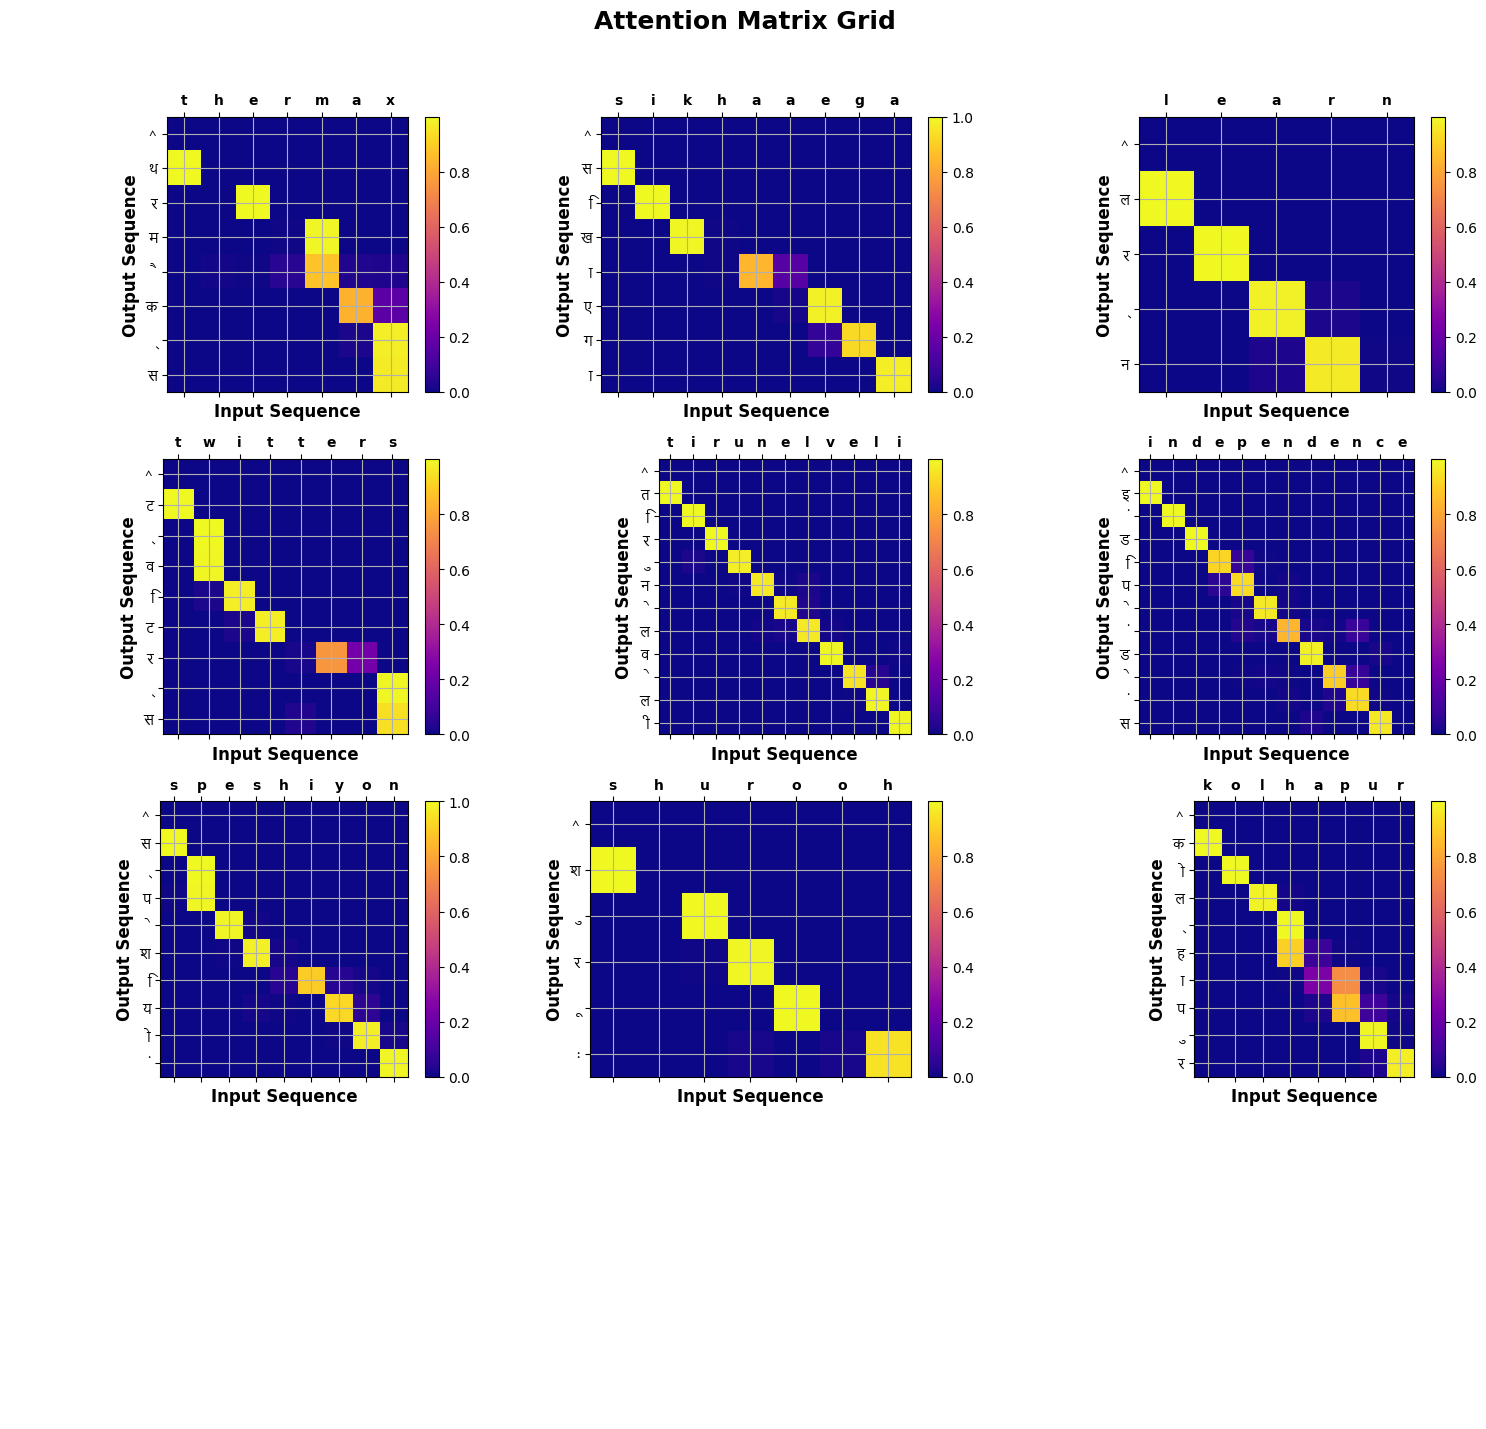

In [ ]:
def plot_attention_grid(sentences, translations, attentions, figsize=(15, 15)):
    fig, axes = plt.subplots(4, 3, figsize=figsize)
    fig.suptitle('Attention Matrix Grid', fontsize=18, fontweight='bold', y=0.95)
    for i in range(9):
        sentence = list(sentences[i])
        translation = list(translations[i])
        attention = attentions[i][:len(translation), :len(sentence)].squeeze(1).detach().numpy()
        ax = axes.flat[i]
        im = ax.matshow(attention, cmap='plasma')  # Using 'viridis' colormap for better readability
        ax.set_xticks(np.arange(len(sentence)))
        ax.set_xticklabels(sentence, size=10, fontweight='bold')  # Bold font for input sequence
        ax.set_yticks(np.arange(len(translation)))
        hindi_font = FontProperties(fname='/kaggle/input/wordcloud-hindi-font/Nirmala.ttf')
        ax.set_yticklabels(translation, size=10, fontproperties=hindi_font, fontweight='bold')  # Bold font for output sequence
        ax.set_xlabel('Input Sequence', fontsize=12, fontweight='bold')  # Bold font for axis labels
        ax.set_ylabel('Output Sequence', fontsize=12, fontweight='bold')  # Bold font for axis labels
        ax.grid(visible=True)  # Hiding grid for cleaner look
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adding colorbar with adjusted position
        
    for ax in axes.flat[9:]:
        ax.axis('off')      
    fig.tight_layout(rect=[0, 0, 1, 0.93])  # Adjusting layout to avoid overlap with title
    wandb.log({"Attention Images": wandb.Image(fig)})
    plt.show()

inputs = []
outputs = []
attentions  = []

for i in range(9):
    input_seq = df_test.iloc[i, 0][:-1]  # Extract input sequence from DataFrame
    output_seq = df_test.iloc[i, 1][:-1]
    predicted_output, attention = predict(model, input_seq, input_char_to_int, output_char_to_int, output_int_to_char)
    attention = attention[:, :, :(len(input_seq))]
    inputs.append(input_seq)
    outputs.append(output_seq)
    attentions.append(attention)
    #print(f"Predicted Output Sequence (beam_search function) {i+1}: {predicted_output_1}\n")
wandb.init(project='DL_Assignment_3', name='Attention_HeatMap')
plot_attention_grid(inputs, outputs, attentions)
wandb.finish()